National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Modern Decision Making: Applied Machine Learning

Final Project: Level of income prediction (binary classification)

Student: Andrei Batyrov (Fall2022)

Date: 19-Nov-2023

##### Table of Contents

[Description](#description)

1. [Data exploration](#data-exploration)

2. [Data preprocessing](#data-preprocessing)

3. [Model training](#model-training)

4. [Summary](#summary)

In [1]:
# Essential import
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats.contingency import crosstab
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 0

Some helper functions.

In [2]:
def describe(series, kind):
    '''
    Print Pandas Series basic statistics.
    '''
    if kind not in ('num', 'cat'):
        raise ValueError("kind must be 'num' or 'cat'")
    if kind == 'cat':
        print(f'Data type: {str(series.dtype)}')
        print(f'{series.nunique():,.0f} unique')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:,.0f} nulls\033[0m')
        else:
            print(f'{nulls:,.0f} nulls')
        print(f"{'':->20}")
        hist = series.value_counts(dropna=False)
        print(hist.to_string(max_rows=10, name=True))
        return hist
    else: # kind == 'num'
        print(f'Data type: {str(series.dtype)}')
        nulls = series.isna().sum()
        if nulls:
            print(f'\033[31m{nulls:,.0f} nulls\033[0m')
        else:
            print(f'{nulls:,.0f} nulls')
        print(f"Min = {series.min():,.2f}")
        print(f"Max = {series.max():,.2f}")
        print(f"Mean = {series.mean():,.2f}")
        print(f"Med = {series.median():,.2f}")
        print(f"Std = {series.std(ddof=1):,.2f}")

In [3]:
def percentile_interval(array, alpha):
    '''
    Return percentiles (boundaries) of `array`, as per the significance level `alpha`.
    '''
    boundaries = np.nanpercentile(array, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # Two-sided percentiles
    return boundaries

In [4]:
def run_chi2test(*sers, alpha=0.05):
    observed_df = pd.DataFrame(crosstab(*sers).count)
    df_index = sers[0].value_counts().index.sort_values()
    df_columns = sers[1].value_counts().index.sort_values()
    observed_df.index = df_index
    observed_df.columns = df_columns
    #print(observed_df.iloc[sorted(np.random.choice(observed_df.shape[0], min(5, observed_df.shape[0]), replace=False))].to_string(sparsify=False, formatters=[lambda x: f'{x:,}']*2))
    print(observed_df.to_string(sparsify=False, max_rows=5))
    print(f"{'':->20}")
    chi2_test_result = chi2_contingency(observed_df.values)
    p_value = chi2_test_result.pvalue
    print(f'{p_value = :.2e} ({alpha = })')
    print(f'`{sers[0].name}` and `{sers[1].name}` are _not_ independent') if p_value < alpha else print(f'`{sers[0].name}` and `{sers[1].name}` are independent')

In [5]:
def plot_hist(array, array2, bins, array2_perc, xlabel, title):
    '''
    Plot two histograms side by side.
    The left histogram plots all values of `array`.
    The right histogram plots within percentiles of `array2`, as per `array2_perc`.
    '''
    alpha = 1.0 - array2_perc / 100
    boundaries = percentile_interval(array, alpha)
    if array2 is not None:
        plt.figure(figsize=(12, 4))
        first = 1
        num_plots = 3
        plt.subplot(1, num_plots, first)
        plt.scatter(array, array2, color='C1', marker='x', alpha=0.25)
        k, b = np.polyfit(array, array2, deg=1)
        fitted_lr = k * array + b
        plt.plot(array, fitted_lr, color='C0', ls='--', label='Fitted LR')
        plt.xlabel(f'{xlabel}', size=10, family='monospace')
        plt.ylabel(f'Target', size=10, family='monospace')
        plt.ylim([array2.min(), array2.max()])
        plt.legend()
        plt.grid(lw=0.5)
    else:
        plt.figure(figsize=(8, 4))
        first = 0
        num_plots = 2
    
    plt.subplot(1, num_plots, first + 1)
    plt.hist(array, bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n(all values)', size=10, family='monospace')
    plt.ylabel('Count', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.subplot(1, num_plots, first + 2)
    plt.hist(array[np.where((array >= boundaries[0]) & (array <= boundaries[1]))], bins=bins, color='C2', alpha=0.75, histtype='step', hatch='.'*6)
    plt.vlines(np.median(array), 0, plt.gca().get_ylim()[1], ls='--', color='C0', label=f"Med = {np.median(array):.1f}")
    plt.xlabel(f'{xlabel}\n({array2_perc}%)', size=10, family='monospace')
    plt.legend()
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)

    plt.suptitle(title, size=10, family='monospace')
    plt.tight_layout();

In [6]:
def plot_bar(df, x, y, xlabel, title, kind='vertical'):
    '''
    Plot bar plot, where `x` and `y` are column names of Pandas Dataframe `df`.
    '''
    if kind not in ('vertical', 'horizontal'):
        raise ValueError("kind must be 'vertical' or 'horizontal'")
    if kind == 'vertical':
        plt.figure(figsize=(6, 4))
        bars = plt.bar(range(df[x].shape[0]), df[y].values, width=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.xticks(range(df[x].shape[0]), df[x].values)
    else: # kind == 'horizontal'
        plt.figure(figsize=(6, 4))
        bars = plt.barh(range(df[x].shape[0]), df[y].values, height=0.25, align='center', color='white', alpha=0.75, hatch='.'*6)
        plt.gca().invert_yaxis()
        plt.xlabel(xlabel, size=10, family='monospace')
        plt.yticks(range(df[x].shape[0]), df[x].values)
    for i in range(len(bars)):
        bars[i].set_edgecolor(f'C{i}')
    plt.gca().set_axisbelow(True)
    plt.grid(lw=0.5)
    plt.title(title, size=10, family='monospace');

In [7]:
def predict_partial(X, feature_name, estimator, kind, grid_size=10, ice_perc=95, feat_perc=95):
    '''
    Calculate partial predictions for one feature with name `feature_name` in Pandas Dataframe `X`.
    Estimator can by any object that has `predict` method: model, pipeline.
    `grid_size` controls the number of values of a feature to generate predictions for.
    Return Pandas DataFrame with:
    - feature values used for predictions, 
    - mean predictions -- this is partial dependence (PD), 
    - Individual Conditional Expectation (ICE) low and high percentiles, as per `ice_perc`
    '''
    if kind not in ('num', 'cat', 'ord'):
        raise ValueError("kind must be 'num', 'cat' or 'ord'")
    grid_size = min(X[feature_name].nunique(), grid_size)
    feature_values = []
    feature_pred_means = []
    ice_los = []
    ice_his = []
    if kind == 'num':
        # For numerical features we can use either all values in its space or bounded by some percentiles
        feature_space = np.linspace(*percentile_interval(X[feature_name], alpha=1.0-feat_perc/100), grid_size)
    elif kind == 'cat':
        feature_space = X[feature_name].unique()[::X[feature_name].nunique() // grid_size]
    else: # kind == 'ord'
        feature_space = X[feature_name].sort_values().unique()[::X[feature_name].nunique() // grid_size]
    for feature_value in feature_space:
        feature_values.append(feature_value)
        feature_new = pd.Series([feature_value] * X.shape[0], name=feature_name) # Fix one feature value for all observations
        # First drop the whole feature, then concatenate its new values, i.e. replace the feature vector
        # Predict with this replaced feature vector
        feature_pred = estimator.predict(pd.concat([X.drop(columns=[feature_name]).reset_index(drop=True), feature_new], axis=1))
        feature_pred_mean = feature_pred.mean() # Partial Dependence
        feature_pred_means.append(feature_pred_mean)
        ice_lo, ice_hi = percentile_interval(feature_pred, alpha=1.0-ice_perc/100) # ICE boundaries
        ice_los.append(ice_lo)
        ice_his.append(ice_hi)
    return pd.DataFrame({'Value': feature_values, 'Pred_mean': feature_pred_means, 'ICE_lo': ice_los, 'ICE_hi': ice_his})

---
# <a id="description"></a>Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/dataset/117/census+income+kdd

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### <a id="data-exploration"></a>[25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?

In [8]:
with open('columns.json', 'r') as fh:
    cols = json.load(fh)['columns']
cols[:5]

['age',
 'class of worker',
 'detailed industry recode',
 'detailed occupation recode',
 'education']

In [9]:
# Load train data
data = pd.read_csv('census-income.data', na_values='?', skipinitialspace=True)
data.columns = cols
# Take a look at some 3 random observations
data.iloc[sorted(np.random.choice(data.shape[0], 3, replace=False))]

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran admin,veterans benefits,weeks worked in year,year,target
8893,20,Self-employed-incorporated,33,38,High school graduate,0,College or university,Never married,Retail trade,Transportation and material moving,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Single,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,815.85,NaN,NaN,NaN,Not in universe under 1 year old,NaN,2,Not in universe,United-States,Puerto-Rico,United-States,Native- Born in the United States,0,Not in universe,2,20,95,- 50000.
151580,55,Not in universe,0,0,7th and 8th grade,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,974.89,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,94,- 50000.
184741,38,Private,25,35,High school graduate,0,Not in universe,Married-civilian spouse present,Manufacturing-nondurable goods,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,2760.62,Nonmover,Nonmover,Nonmover,Yes,Not in universe,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,50000+.


In [10]:
data.shape

(199522, 42)

First, let's examine the target variable.

Data type: object
2 unique
0 nulls
--------------------
target
- 50000.    187140
50000+.      12382
Name: count


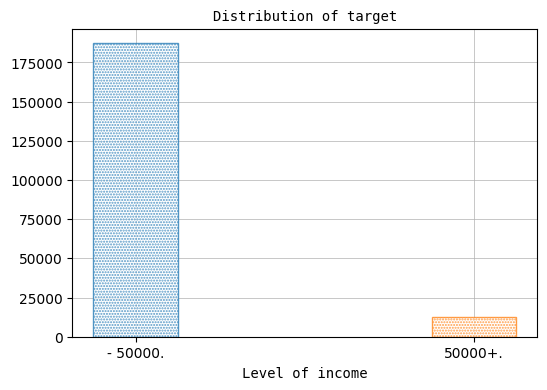

In [11]:
target = 'target'
hist = pd.DataFrame(describe(data[target], 'cat')).reset_index()
plot_bar(hist, target, 'count', 'Level of income', 'Distribution of target')

We can clearly see that the target variable takes only two values (levels of income). Also, note that the distribution of the target is not uniform (right-skewed), i.e. we have highly imbalanced data. Therefore, we __cannot use__ the `accuracy score` for this task to evaluate our classifier(s). Indeed, let's construct a naive classifier that will always predict the most frequent level of income which is "`- 50000.`", and compute the accuracy score for such predictions.

In [12]:
y_pred_naive = np.ones_like(data[target]) * hist[target][0]
print(f'Predicted level of income: {y_pred_naive[:5]} ...')
print(f"Naive classifier's accuracy = {accuracy_score(data[target], y_pred_naive):.2%}")

Predicted level of income: ['- 50000.' '- 50000.' '- 50000.' '- 50000.' '- 50000.'] ...
Naive classifier's accuracy = 93.79%


Is the task solved? Well, if we're only interested in reporting the frequency of the "`- 50000.`" income level, regardless of any other features in our data, then yes. However, __let's assume that we're interested in predicting the positive effect__ from observing our features. In other words, we would like to understand the profile of those participants who earn more. Let predicting the level of income "`50000+.`" be the positive effect (positive `Class 1`), and predicting the level of income "`- 50000.`" be the negative effect (negative `Class 0`). Thus, we will be solving a binary classification problem in this task. Since, we're interested in the positive class, we will focus on the `precision`, `recall (tpr)`, and `f1 score` metrics to evaluate how well our classifier(s) can predict the positive class. In addition, we will also look at the `tpr` and `fpr` metrics to evaluate how well our classifier(s) can distinguish between the positive and negative classes.

Now, let's encode the target variable as `1` and `0` for the further analysis. Don' forget to check that the encoding is done correctly.

Data type: int32
2 unique
0 nulls
--------------------
target
0    187140
1     12382
Name: count


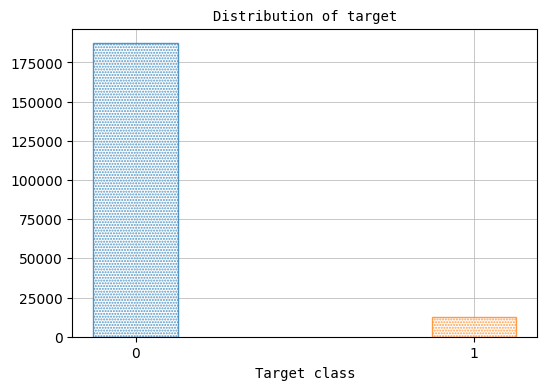

In [13]:
target_label_enc = LabelEncoder()
data[target] = target_label_enc.fit_transform(data[target])
hist = pd.DataFrame(describe(data[target], 'cat')).reset_index()
plot_bar(hist, target, 'count', 'Target class', 'Distribution of target')

---
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step

Let's choose the __Stratified K-Fold cross-validation strategy__ applied on the train data. It is a variation of the K-Fold cross-validation strategy that uses stratified folds. This strategy allows to keep proportions of observations selected into folds, as per the target class distribution, thus taking into account the imbalance of our data.

The advantages of this strategy:
- it does not require any additional validation data for, since the validation samples are constructed from the train data itself;
- it does not require any preprocessing of the train data, since the folds are created during the very process of cross-validation on the fly.

However, this strategy has disadvantages too:
- since one of the folds is used for validation, not all train data is used for fitting a model in every training round;
- a model has to be trained as many times as there are folds, which takes time.

---
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

Now, let's look closer at our predictors (features).

In [14]:
data.drop(columns=target).dtypes

age                                           int64
class of worker                              object
detailed industry recode                      int64
detailed occupation recode                    int64
education                                    object
wage per hour                                 int64
enroll in edu inst last wk                   object
marital stat                                 object
major industry code                          object
major occupation code                        object
race                                         object
hispanic origin                              object
sex                                          object
member of a labor union                      object
reason for unemployment                      object
full or part time employment stat            object
capital gains                                 int64
capital losses                                int64
dividends from stocks                         int64
tax filer st

In [15]:
data.drop(columns=target).columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'instance weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
 

In [16]:
num_cols, cat_cols, ord_cols = [], [], []

Pearson corr coef with target = 0.14
Data type: int64
0 nulls
Min = 0.00
Max = 90.00
Mean = 34.49
Med = 33.00
Std = 22.31


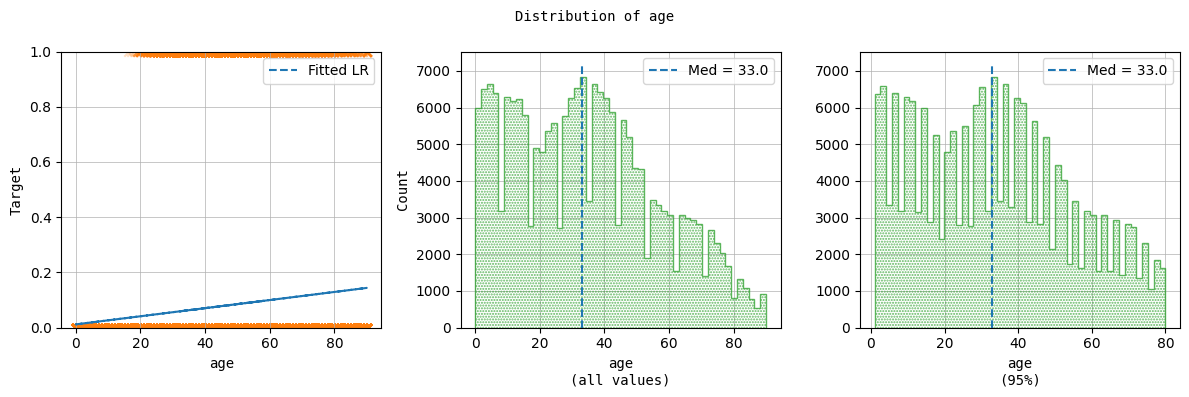

In [17]:
# 1. Age
feature_name = 'age'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 95, feature_name, f'Distribution of {feature_name}')

`age` looks like a continuous variable. It is rather loosely linearly correlated with the target: class 0 is covered by all ages, while in class 1 the age starts at around 20 years. We will use this variable in our model.

In [18]:
num_cols.append(feature_name)

In [19]:
# 2. Class of worker
feature_name = 'class of worker'
_ = describe(data[feature_name], 'cat')

Data type: object
9 unique
0 nulls
--------------------
class of worker
Not in universe                   100244
Private                            72028
Self-employed-not incorporated      8445
Local government                    7784
State government                    4227
Self-employed-incorporated          3265
Federal government                  2925
Never worked                         439
Without pay                          165
Name: count


Since, `class of worker` looks to be a categorical feature, let's check association with target by using $\chi^2$-test. We will run such tests for all category variables below. Also, note, that for all $\chi^2$-tests below, for simplicity, we'll rather ignore the $\chi^2$-test's requirement of more than 5 counts in the contingency table cells.

In [20]:
run_chi2test(data[feature_name], data[target])

target                 0    1
class of worker              
Federal government  2328  597
Local government    6937  847
...                  ...  ...
State government    3742  485
Without pay          164    1
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`class of worker` and `target` are _not_ independent


We have confirmed that `class of worker` and target are not independent indeed, thus we will use this feature in our model.

In [21]:
cat_cols.append(feature_name)

In [22]:
# 3. Detailed industry recode
feature_name = 'detailed industry recode'
_ = describe(data[feature_name], 'cat')

Data type: int64
52 unique
0 nulls
--------------------
detailed industry recode
0     100683
33     17070
43      8283
4       5984
42      4683
       ...  
28       143
26       127
51        36
20        32
10         4
Name: count


In [23]:
run_chi2test(data[feature_name], data[target])

target                        0    1
detailed industry recode            
0                         99777  906
1                           780   47
...                         ...  ...
50                         1407  297
51                           28    8
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed industry recode` and `target` are _not_ independent


We have confirmed that `detailed industry recode` and target are not independent indeed, thus we will use this feature in our model.

In [24]:
cat_cols.append(feature_name)

In [25]:
# 4. Detailed occupation recode
feature_name = 'detailed occupation recode'
_ = describe(data[feature_name], 'cat')

Data type: int64
47 unique
0 nulls
--------------------
detailed occupation recode
0     100683
2       8756
26      7887
19      5413
29      5105
       ...  
6        441
22       411
45       172
20        71
46        36
Name: count


In [26]:
run_chi2test(data[feature_name], data[target])

target                          0    1
detailed occupation recode            
0                           99777  906
1                             411  133
...                           ...  ...
45                            152   20
46                             28    8
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed occupation recode` and `target` are _not_ independent


We have confirmed that `detailed occupation recode` and target are not independent indeed, thus we will use this feature in our model.

In [27]:
cat_cols.append(feature_name)

In [28]:
# 5. Education
feature_name = 'education'
_ = describe(data[feature_name], 'cat')

Data type: object
17 unique
0 nulls
--------------------
education
High school graduate                      48406
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
                                          ...  
12th grade no diploma                      2126
1st 2nd 3rd or 4th grade                   1799
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Less than 1st grade                         819
Name: count


In [29]:
run_chi2test(data[feature_name], data[target])

target                                      0     1
education                                          
10th grade                               7495    62
11th grade                               6806    70
...                                       ...   ...
Prof school degree (MD DDS DVM LLB JD)    824   969
Some college but no degree              26033  1787
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`education` and `target` are _not_ independent


We have confirmed that `education` and target are not independent indeed, thus we will use this feature in our model.

In [30]:
cat_cols.append(feature_name)

Pearson corr coef with target = 0.02
Data type: int64
0 nulls
Min = 0.00
Max = 9,999.00
Mean = 55.43
Med = 0.00
Std = 274.90


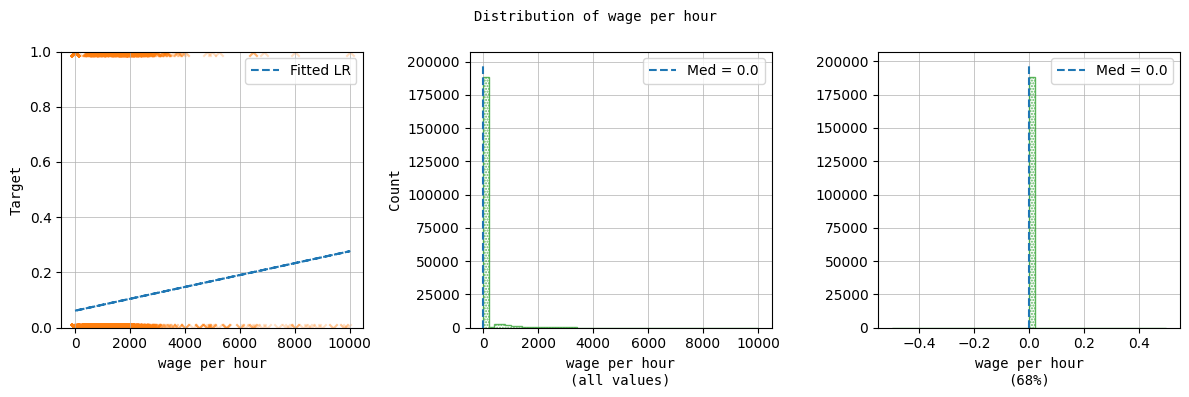

In [31]:
# 6. Wage per hour
feature_name = 'wage per hour'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 68, feature_name, f'Distribution of {feature_name}')

`wage per hour` looks like a continuous variable. It is almost not linearly correlated with the target. It has too many values of 0.0, which does not add any valuable information to our analysis. Thus, we will not use this variable in our model.

In [32]:
# 7. Enroll in edu inst last wk
feature_name = 'enroll in edu inst last wk'
_ = describe(data[feature_name], 'cat')

Data type: object
3 unique
0 nulls
--------------------
enroll in edu inst last wk
Not in universe          186942
High school                6892
College or university      5688
Name: count


In [33]:
run_chi2test(data[feature_name], data[target])

target                           0      1
enroll in edu inst last wk               
College or university         5663     25
High school                   6887      5
Not in universe             174590  12352
--------------------
p_value = 3.02e-179 (alpha = 0.05)
`enroll in edu inst last wk` and `target` are _not_ independent


We have confirmed that `enroll in edu inst last wk` and target are not independent indeed, thus we will use this feature in our model. Interestingly, there are high school students who earn more than 50,000.

In [34]:
cat_cols.append(feature_name)

In [35]:
# 8. Marital stat
feature_name = 'marital stat'
_ = describe(data[feature_name], 'cat')

Data type: object
7 unique
0 nulls
--------------------
marital stat
Never married                      86485
Married-civilian spouse present    84222
Divorced                           12710
Widowed                            10462
Separated                           3460
Married-spouse absent               1518
Married-A F spouse present           665
Name: count


In [36]:
run_chi2test(data[feature_name], data[target])

target                          0     1
marital stat                           
Divorced                    11644  1066
Married-A F spouse present    650    15
...                           ...   ...
Separated                    3302   158
Widowed                     10132   330
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`marital stat` and `target` are _not_ independent


We have confirmed that `marital stat` and target are not independent indeed, thus we will use this feature in our model.

In [37]:
cat_cols.append(feature_name)

In [38]:
# 9. Major industry code
feature_name = 'major industry code'
_ = describe(data[feature_name], 'cat')

Data type: object
24 unique
0 nulls
--------------------
major industry code
Not in universe or children        100683
Retail trade                        17070
Manufacturing-durable goods          9015
Education                            8283
Manufacturing-nondurable goods       6897
                                    ...  
Utilities and sanitary services      1178
Private household services            945
Mining                                563
Forestry and fisheries                187
Armed Forces                           36
Name: count


In [39]:
run_chi2test(data[feature_name], data[target])

target                              0    1
major industry code                       
Agriculture                      2845  178
Armed Forces                       28    8
...                               ...  ...
Utilities and sanitary services   922  256
Wholesale trade                  3044  552
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`major industry code` and `target` are _not_ independent


We have confirmed that `major industry code` and target are not independent indeed, thus we will use this feature in our model.

In [40]:
cat_cols.append(feature_name)

In [41]:
# 10. Major occupation code
feature_name = 'major occupation code'
_ = describe(data[feature_name], 'cat')

Data type: object
15 unique
0 nulls
--------------------
major occupation code
Not in universe                    100683
Adm support including clerical      14837
Professional specialty              13940
Executive admin and managerial      12495
Other service                       12099
                                    ...  
Farming forestry and fishing         3146
Technicians and related support      3018
Protective services                  1661
Private household services            780
Armed Forces                           36
Name: count


In [42]:
run_chi2test(data[feature_name], data[target])

target                                  0    1
major occupation code                         
Adm support including clerical      14391  446
Armed Forces                           28    8
...                                   ...  ...
Technicians and related support      2657  361
Transportation and material moving   3761  259
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`major occupation code` and `target` are _not_ independent


We have confirmed that `major occupation code` and target are not independent indeed, thus we will use this feature in our model.

In [43]:
cat_cols.append(feature_name)

In [44]:
# 11. Race
feature_name = 'race'
_ = describe(data[feature_name], 'cat')

Data type: object
5 unique
0 nulls
--------------------
race
White                          167364
Black                           20415
Asian or Pacific Islander        5835
Other                            3657
Amer Indian Aleut or Eskimo      2251
Name: count


In [45]:
run_chi2test(data[feature_name], data[target])

target                            0      1
race                                      
Amer Indian Aleut or Eskimo    2202     49
Asian or Pacific Islander      5405    430
Black                         19875    540
Other                          3566     91
White                        156092  11272
--------------------
p_value = 1.15e-147 (alpha = 0.05)
`race` and `target` are _not_ independent


We have confirmed that `race` and target are not independent indeed, thus we will use this feature in our model.

In [46]:
cat_cols.append(feature_name)

In [47]:
# 12. Hispanic origin
feature_name = 'hispanic origin'
_ = describe(data[feature_name], 'cat')

Data type: object
9 unique
874 nulls
--------------------
hispanic origin
All other                    171906
Mexican-American               8079
Mexican (Mexicano)             7234
Central or South American      3895
Puerto Rican                   3313
Other Spanish                  2485
Cuban                          1126
NaN                             874
Do not know                     306
Chicano                         304
Name: count


In [50]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                          0      1
hispanic origin                         
All other                  160139  11767
Central or South American    3815     80
...                           ...    ...
Puerto Rican                 3245     68
Unknown                       817     57
--------------------
p_value = 2.22e-196 (alpha = 0.05)
`hispanic origin` and `target` are _not_ independent


We have confirmed that `hispanic origin` and target are not independent indeed, thus we will use this feature in our model.

In [51]:
cat_cols.append(feature_name)

In [52]:
# 13. Sex
feature_name = 'sex'
_ = describe(data[feature_name], 'cat')

Data type: object
2 unique
0 nulls
--------------------
sex
Female    103983
Male       95539
Name: count


In [53]:
run_chi2test(data[feature_name], data[target])

target       0     1
sex                 
Female  101320  2663
Male     85820  9719
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`sex` and `target` are _not_ independent


We have confirmed that `sex` and target are not independent indeed, thus we will use this feature in our model. Interestingly, men look to earn more than women.

In [54]:
cat_cols.append(feature_name)

In [55]:
# 14. Member of a labor union
feature_name = 'member of a labor union'
_ = describe(data[feature_name], 'cat')

Data type: object
3 unique
0 nulls
--------------------
member of a labor union
Not in universe    180458
No                  16034
Yes                  3030
Name: count


In [56]:
run_chi2test(data[feature_name], data[target])

target                        0      1
member of a labor union               
No                        14212   1822
Not in universe          170310  10148
Yes                        2618    412
--------------------
p_value = 1.99e-244 (alpha = 0.05)
`member of a labor union` and `target` are _not_ independent


We have confirmed that `member of a labor union` and target are not independent indeed, thus we will use this feature in our model.

In [57]:
cat_cols.append(feature_name)

In [58]:
# 15. Reason for unemployment
feature_name = 'reason for unemployment'
_ = describe(data[feature_name], 'cat')

Data type: object
6 unique
0 nulls
--------------------
reason for unemployment
Not in universe          193452
Other job loser            2038
Re-entrant                 2019
Job loser - on layoff       976
Job leaver                  598
New entrant                 439
Name: count


In [59]:
run_chi2test(data[feature_name], data[target])

target                      0   1
reason for unemployment          
Job leaver                574  24
Job loser - on layoff     954  22
...                       ...  ..
Other job loser          1939  99
Re-entrant               1996  23
--------------------
p_value = 1.01e-31 (alpha = 0.05)
`reason for unemployment` and `target` are _not_ independent


We have confirmed that `reason for unemployment` and target are not independent indeed, thus we will use this feature in our model.

In [60]:
cat_cols.append(feature_name)

In [61]:
# 16. Full or part time employment stat
feature_name = 'full or part time employment stat'
_ = describe(data[feature_name], 'cat')

Data type: object
8 unique
0 nulls
--------------------
full or part time employment stat
Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26807
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
PT for econ reasons usually PT          1209
Unemployed part- time                    843
PT for econ reasons usually FT           525
Name: count


In [62]:
run_chi2test(data[feature_name], data[target])

target                                  0     1
full or part time employment stat              
Children or Armed Forces           117895  5874
Full-time schedules                 35370  5366
...                                   ...   ...
Unemployed full-time                 2228    83
Unemployed part- time                 825    18
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`full or part time employment stat` and `target` are _not_ independent


We have confirmed that `full or part time employment stat` and target are not independent indeed, thus we will use this feature in our model.

In [63]:
cat_cols.append(feature_name)

Pearson corr coef with target = 0.24
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 434.72
Med = 0.00
Std = 4,697.54


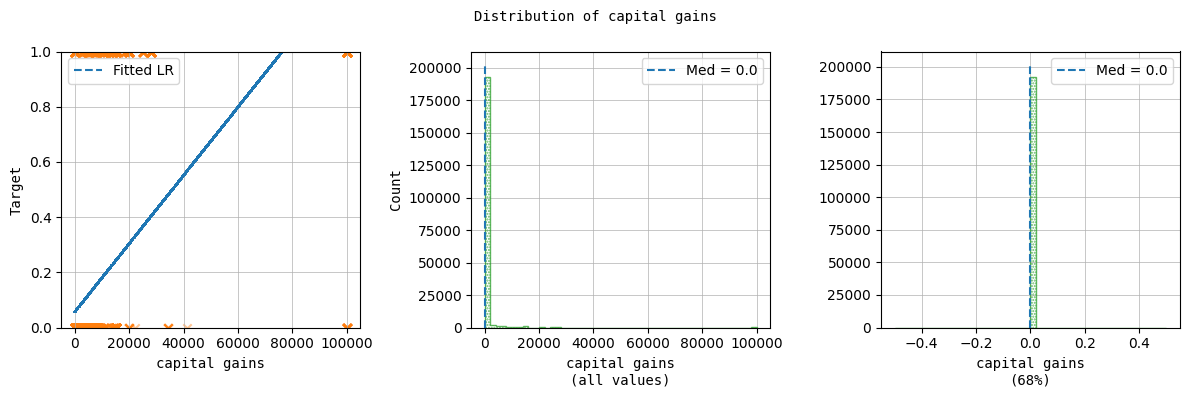

In [64]:
# 17. Capital gains
feature_name = 'capital gains'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 68, feature_name, f'Distribution of {feature_name}')

`capital gains` looks like a continuous variable. It is rather loosely linearly correlated with the target. It has too many values of 0.0, which does not add any valuable information to our analysis. Thus, we will not use this variable in our model.

Pearson corr coef with target = 0.15
Data type: int64
0 nulls
Min = 0.00
Max = 4,608.00
Mean = 37.31
Med = 0.00
Std = 271.90


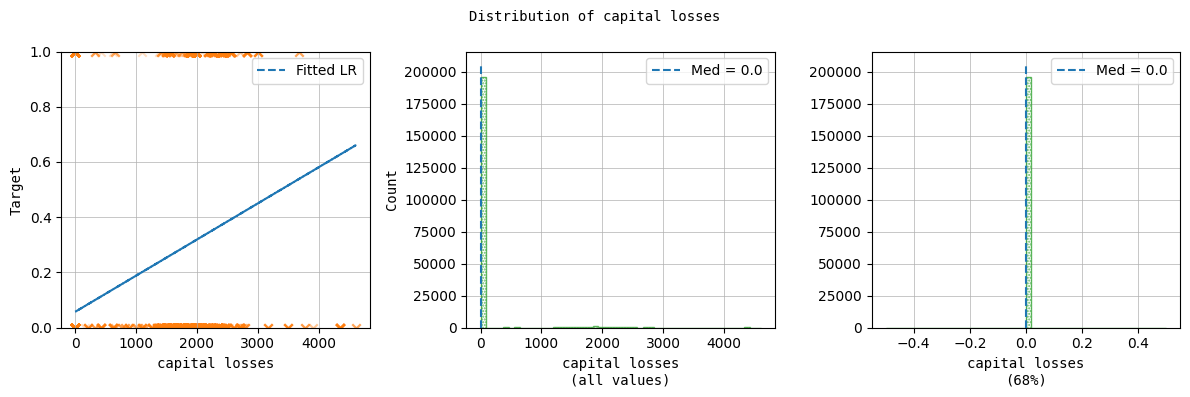

In [65]:
# 18. Capital losses
feature_name = 'capital losses'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 68, feature_name, f'Distribution of {feature_name}')

`capital losses` looks like a continuous variable. It is almost not linearly correlated with the target. It has too many values of 0.0, which does not add any valuable information to our analysis. Thus, we will not use this variable in our model.

Pearson corr coef with target = 0.18
Data type: int64
0 nulls
Min = 0.00
Max = 99,999.00
Mean = 197.53
Med = 0.00
Std = 1,984.17


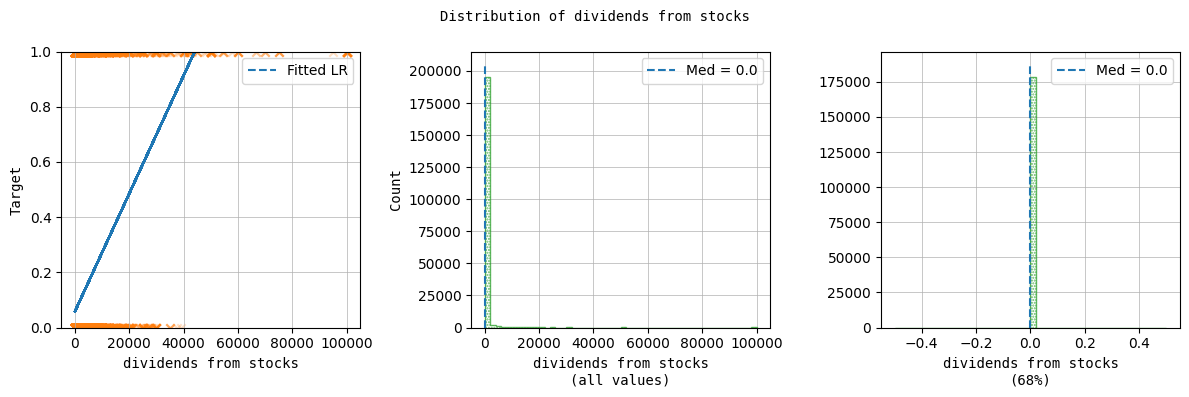

In [66]:
# 19. Dividends from stocks
feature_name = 'dividends from stocks'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 68, feature_name, f'Distribution of {feature_name}')

`dividends from stocks` looks like a continuous variable. It is almost not linearly correlated with the target. It has too many values of 0.0, which does not add any valuable information to our analysis. Thus, we will not use this variable in our model.

In [67]:
# 20. Tax filer stat
feature_name = 'tax filer stat'
_ = describe(data[feature_name], 'cat')

Data type: object
6 unique
0 nulls
--------------------
tax filer stat
Nonfiler                        75093
Joint both under 65             67383
Single                          37421
Joint both 65+                   8332
Head of household                7426
Joint one under 65 & one 65+     3867
Name: count


In [68]:
run_chi2test(data[feature_name], data[target])

target                 0     1
tax filer stat                
Head of household   6978   448
Joint both 65+      7882   450
...                  ...   ...
Nonfiler           75058    35
Single             35126  2295
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`tax filer stat` and `target` are _not_ independent


We have confirmed that `tax filer stat` and target are not independent indeed, thus we will use this feature in our model.

In [69]:
cat_cols.append(feature_name)

In [70]:
# 21. Region of previous residence
feature_name = 'region of previous residence'
_ = describe(data[feature_name], 'cat')

Data type: object
6 unique
0 nulls
--------------------
region of previous residence
Not in universe    183749
South                4889
West                 4074
Midwest              3575
Northeast            2705
Abroad                530
Name: count


In [71]:
run_chi2test(data[feature_name], data[target])

target                           0    1
region of previous residence           
Abroad                         512   18
Midwest                       3466  109
...                            ...  ...
South                         4705  184
West                          3914  160
--------------------
p_value = 8.16e-35 (alpha = 0.05)
`region of previous residence` and `target` are _not_ independent


We have confirmed that `region of previous residence` and target are not independent indeed, thus we will use this feature in our model.

In [72]:
cat_cols.append(feature_name)

In [73]:
# 22. State of previous residence
feature_name = 'state of previous residence'
_ = describe(data[feature_name], 'cat')

Data type: object
50 unique
708 nulls
--------------------
state of previous residence
Not in universe    183749
California           1714
Utah                 1063
Florida               849
North Carolina        812
                    ...  
Wisconsin             105
South Carolina         95
New Jersey             75
Delaware               73
Idaho                  31
Name: count


In [75]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                         0   1
state of previous residence         
Abroad                       648  23
Alabama                      210   6
...                          ...  ..
Wisconsin                    100   5
Wyoming                      231  10
--------------------
p_value = 3.05e-23 (alpha = 0.05)
`state of previous residence` and `target` are _not_ independent


We have confirmed that `state of previous residence` and target are not independent indeed, thus we will use this feature in our model.

In [76]:
cat_cols.append(feature_name)

In [77]:
# 23. Detailed household and family stat
feature_name = 'detailed household and family stat'
_ = describe(data[feature_name], 'cat')

Data type: object
38 unique
0 nulls
--------------------
detailed household and family stat
Householder                                  53248
Child <18 never marr not in subfamily        50326
Spouse of householder                        41695
Nonfamily householder                        22213
Child 18+ never marr Not in a subfamily      12030
                                             ...  
Other Rel <18 spouse of subfamily RP             3
Child <18 spouse of subfamily RP                 2
Grandchild <18 never marr RP of subfamily        2
Grandchild <18 ever marr not in subfamily        2
Other Rel <18 ever marr not in subfamily         1
Name: count


In [78]:
run_chi2test(data[feature_name], data[target])

target                                      0     1
detailed household and family stat                 
Child 18+ ever marr Not in a subfamily    990    23
Child 18+ ever marr RP of subfamily       659    12
...                                       ...   ...
Spouse of RP of unrelated subfamily        47     5
Spouse of householder                   39413  2282
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed household and family stat` and `target` are _not_ independent


We have confirmed that `detailed household and family stat` and target are not independent indeed, thus we will use this feature in our model.

In [79]:
cat_cols.append(feature_name)

In [80]:
# 24. Detailed household summary in household
feature_name = 'detailed household summary in household'
_ = describe(data[feature_name], 'cat')

Data type: object
8 unique
0 nulls
--------------------
detailed household summary in household
Householder                             75475
Child under 18 never married            50426
Spouse of householder                   41709
Child 18 or older                       14430
Other relative of householder            9702
Nonrelative of householder               7601
Group Quarters- Secondary individual      132
Child under 18 ever married                47
Name: count


In [81]:
run_chi2test(data[feature_name], data[target])

target                                       0     1
detailed household summary in household             
Child 18 or older                        14304   126
Child under 18 ever married                 47     0
...                                        ...   ...
Other relative of householder             9616    86
Spouse of householder                    39427  2282
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`detailed household summary in household` and `target` are _not_ independent


We have confirmed that `detailed household summary in household` and target are not independent indeed, thus we will use this feature in our model.

In [82]:
cat_cols.append(feature_name)

Pearson corr coef with target = 0.01
Data type: float64
0 nulls
Min = 37.87
Max = 18,656.30
Mean = 1,740.38
Med = 1,618.31
Std = 993.77


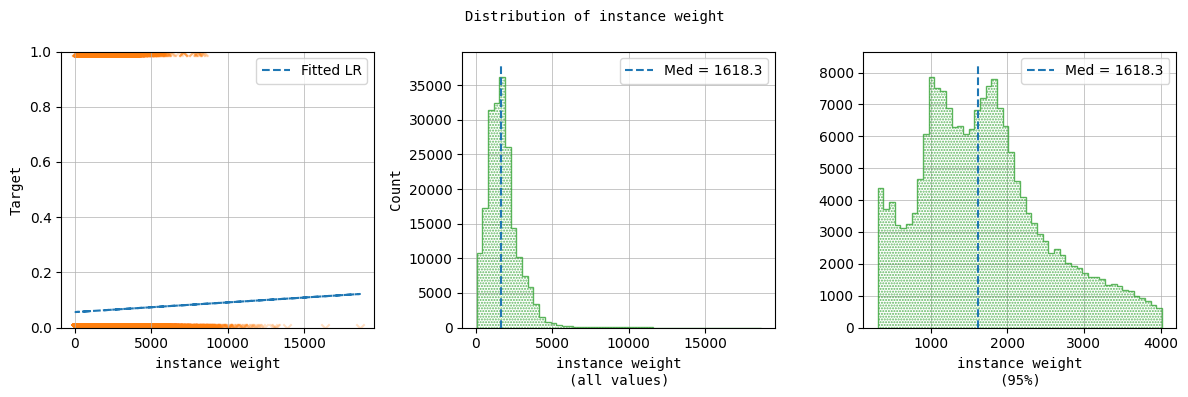

In [83]:
# 25. Instance weight
feature_name = 'instance weight'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 95, feature_name, f'Distribution of {feature_name}')

`instance weight` looks like a continuous variable. It is almost not linearly correlated with the target. We will use this variable in our model.

In [84]:
num_cols.append(feature_name)

In [85]:
# 26. Migration code-change in msa
feature_name = 'migration code-change in msa'
_ = describe(data[feature_name], 'cat')

Data type: object
9 unique
99,695 nulls
--------------------
migration code-change in msa
NaN                 99695
Nonmover            82538
MSA to MSA          10601
NonMSA to nonMSA     2811
Not in universe      1516
MSA to nonMSA         790
NonMSA to MSA         615
Abroad to MSA         453
Not identifiable      430
Abroad to nonMSA       73
Name: count


In [87]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                            0     1
migration code-change in msa             
Abroad to MSA                   435    18
Abroad to nonMSA                 73     0
...                             ...   ...
Not in universe                1516     0
Unknown                       93152  6543
--------------------
p_value = 5.35e-59 (alpha = 0.05)
`migration code-change in msa` and `target` are _not_ independent


We have confirmed that `migration code-change in msa` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [91]:
cat_cols.append(feature_name)

In [92]:
# 27. Migration code-change in reg
feature_name = 'migration code-change in reg'
_ = describe(data[feature_name], 'cat')

Data type: object
8 unique
99,695 nulls
--------------------
migration code-change in reg
NaN                               99695
Nonmover                          82538
Same county                        9812
Different county same state        2797
Not in universe                    1516
Different region                   1178
Different state same division       991
Abroad                              530
Different division same region      465
Name: count


In [93]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                            0     1
migration code-change in reg             
Abroad                          512    18
Different county same state    2670   127
...                             ...   ...
Same county                    9484   328
Unknown                       93152  6543
--------------------
p_value = 1.34e-57 (alpha = 0.05)
`migration code-change in reg` and `target` are _not_ independent


We have confirmed that `migration code-change in reg` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [95]:
cat_cols.append(feature_name)

In [96]:
# 28. Migration code-move within reg
feature_name = 'migration code-move within reg'
_ = describe(data[feature_name], 'cat')

Data type: object
9 unique
99,695 nulls
--------------------
migration code-move within reg
NaN                             99695
Nonmover                        82538
Same county                      9812
Different county same state      2797
Not in universe                  1516
Different state in South          973
Different state in West           679
Different state in Midwest        551
Abroad                            530
Different state in Northeast      431
Name: count


In [97]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                              0     1
migration code-move within reg             
Abroad                            512    18
Different county same state      2670   127
...                               ...   ...
Same county                      9484   328
Unknown                         93152  6543
--------------------
p_value = 8.62e-57 (alpha = 0.05)
`migration code-move within reg` and `target` are _not_ independent


We have confirmed that `migration code-move within reg` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [ ]:
cat_cols.append(feature_name)

In [98]:
# 29. Live in this house 1 year ago
feature_name = 'live in this house 1 year ago'
_ = describe(data[feature_name], 'cat')

Data type: object
3 unique
0 nulls
--------------------
live in this house 1 year ago
Not in universe under 1 year old    101211
Yes                                  82538
No                                   15773
Name: count


In [99]:
run_chi2test(data[feature_name], data[target])

target                                0     1
live in this house 1 year ago                
No                                15155   618
Not in universe under 1 year old  94668  6543
Yes                               77317  5221
--------------------
p_value = 1.70e-34 (alpha = 0.05)
`live in this house 1 year ago` and `target` are _not_ independent


We have confirmed that `live in this house 1 year ago` and target are not independent indeed, thus we will use this feature in our model.

In [100]:
cat_cols.append(feature_name)

In [101]:
# 30. Migration prev res in sunbelt
feature_name = 'migration prev res in sunbelt'
_ = describe(data[feature_name], 'cat')

Data type: object
3 unique
99,695 nulls
--------------------
migration prev res in sunbelt
NaN                99695
Not in universe    84054
No                  9987
Yes                 5786
Name: count


In [102]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                             0     1
migration prev res in sunbelt             
No                              9563   424
Not in universe                78833  5221
Unknown                        93152  6543
Yes                             5592   194
--------------------
p_value = 2.43e-36 (alpha = 0.05)
`migration prev res in sunbelt` and `target` are _not_ independent


We have confirmed that `migration prev res in sunbelt` and target are not independent indeed, thus we will use this feature in our model. Note that this variable has around 50% of missing values.

In [ ]:
cat_cols.append(feature_name)

Pearson corr coef with target = 0.22
Data type: int64
0 nulls
Min = 0.00
Max = 6.00
Mean = 1.96
Med = 1.00
Std = 2.37


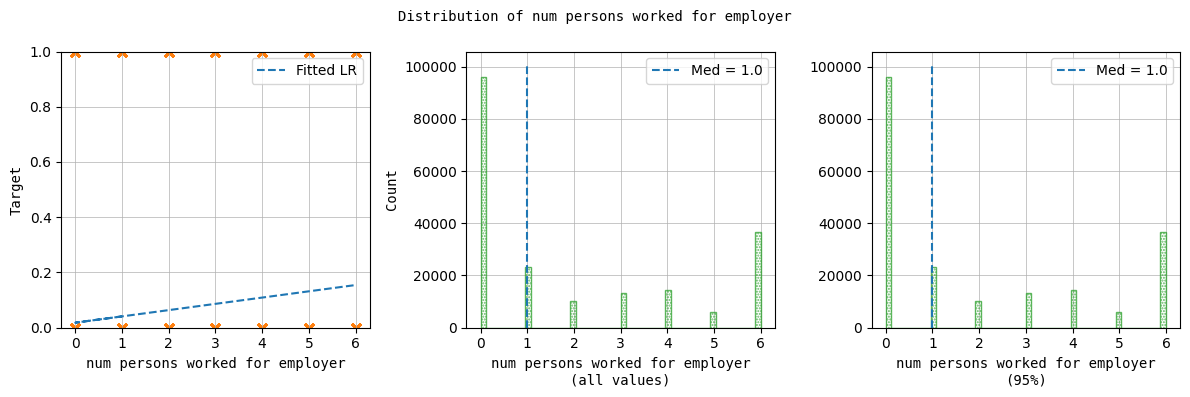

In [111]:
# 31. Num persons worked for employer
feature_name = 'num persons worked for employer'
print(f"Pearson corr coef with target = {data[feature_name].corr(data[target]):.2f}")
describe(data[feature_name], 'num')
plot_hist(data[feature_name].values, data[target].values, 50, 95, feature_name, f'Distribution of {feature_name}')

`num persons worked for employer` looks like a continuous variable but with few values. It is rather loosely linearly correlated with the target. Since it has few distinct integer values, we can also check if it is associated with the target.

In [112]:
run_chi2test(data[feature_name], data[target])

target                               0     1
num persons worked for employer             
0                                95386   596
1                                21016  2093
...                                ...   ...
5                                 5370   665
6                                31031  5480
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`num persons worked for employer` and `target` are _not_ independent


We have confirmed that `num persons worked for employer` and target are not independent indeed, thus we will use this feature in our model.

In [113]:
num_cols.append(feature_name)

In [114]:
# 32. Family members under 18
feature_name = 'family members under 18'
_ = describe(data[feature_name], 'cat')

Data type: object
5 unique
0 nulls
--------------------
family members under 18
Not in universe           144231
Both parents present       38983
Mother only present        12772
Father only present         1883
Neither parent present      1653
Name: count


In [115]:
run_chi2test(data[feature_name], data[target])

target                        0      1
family members under 18               
Both parents present      38981      2
Father only present        1883      0
Mother only present       12772      0
Neither parent present     1653      0
Not in universe          131851  12380
--------------------
p_value = 0.00e+00 (alpha = 0.05)
`family members under 18` and `target` are _not_ independent


We have confirmed that `family members under 18` and target are not independent indeed, thus we will use this feature in our model.

In [117]:
cat_cols.append(feature_name)

Data type: object
42 unique
6,713 nulls
--------------------
country of birth father
United-States         159162
Mexico                 10008
NaN                     6713
Puerto-Rico             2680
Italy                   2212
                       ...  
Trinadad&Tobago          113
Thailand                 107
Hong Kong                106
Holand-Netherlands        51
Panama                    25
Name: count


In [ ]:
# 33. Country of birth father
feature_name = 'country of birth father'
_ = describe(data[feature_name], 'cat')

In [118]:
run_chi2test(data[feature_name].fillna('Unknown'), data[target]) # Temporarily impute missing values

target                      0    1
country of birth father           
Cambodia                  191    5
Canada                   1250  130
...                       ...  ...
Vietnam                   446   11
Yugoslavia                202   15
--------------------
p_value = 1.86e-186 (alpha = 0.05)
`country of birth father` and `target` are _not_ independent


We have confirmed that `country of birth father` and target are not independent indeed, thus we will use this feature in our model.

In [ ]:
cat_cols.append(feature_name)

### <a id="data-preprocessing"></a>[25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)

In [88]:
# Check nulls
data.isna().sum().sum()

416587

* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding

* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### <a id="model-training"></a>[25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)

* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models

* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### <a id="summary"></a>[25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?

* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)

* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero